In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math

In [2]:
#load NAB data
data_path = 'benchmark/dataset'
data_info = pd.read_excel('benchmark/data.xlsx', index_col = 0)
dataset = 'NAB'

data_name = os.listdir(data_path + '/NAB/NAB_data')
label_name = os.listdir(data_path + '/NAB/NAB_label')
data_name.sort()
label_name.sort()
data = np.loadtxt(data_path + '/NAB/NAB_data/' + data_name[0] )
label = np.loadtxt(data_path + '/NAB/NAB_label/' + label_name[0] )[:-1] #for some reason the last entry of data ts is lost..

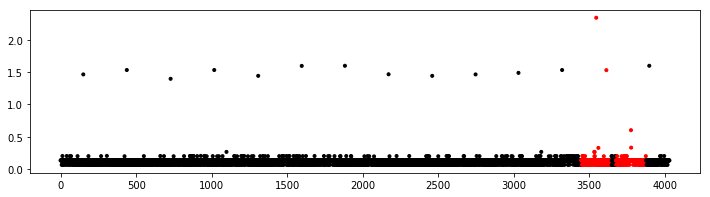

In [3]:
#plot the data
plt.figure(figsize=(12, 3))
cf = np.vectorize(lambda x: 'r' if (x == 1) else 'k')
plt.scatter(np.arange(data.shape[0]), data, c=cf(label), marker = '.')

In [4]:
##Prediction Based Model 
##For example, polynomial 
from ptsa.models.poly import Poly
model = Poly(window = 200, power = 0)
model.fit(data)

/anaconda3/lib/python3.7/site-packages/ptsa/utils/utility.py:672: UserWarning: No igraph interface for plotting trees
  warnings.warn("No igraph interface for plotting trees")


Poly(contamination=0.1, neighborhood=2000, power=0, window=200)

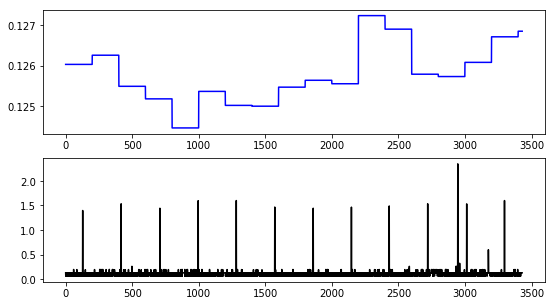

In [5]:
#Prediction model estimates the timeseries from the supported region. We plot the estimation and the original below
fig, axs = plt.subplots(2, figsize=(9, 5))
axs[0].plot(model.estimation[600:], c = 'b')
axs[1].plot(data[600:], c = 'k')

In [6]:
#The dissimilarity measure between estimation and the real one will determine the anomaly score
#We use Fourier measure as an example
from ptsa.models.distance import Fourier
measure = Fourier()
measure.detector = model
measure.set_param()
model.decision_function(measure=measure)

Poly(contamination=0.1, neighborhood=2000, power=0, window=200)

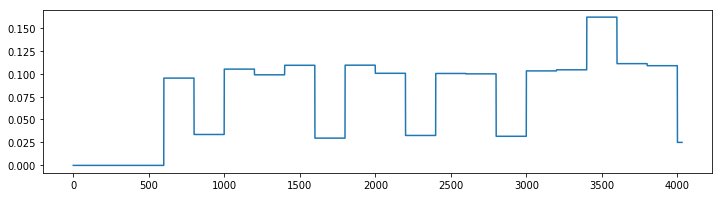

In [7]:
#We plot the raw anomaly score for polynomial
plt.figure(figsize=(12, 3))
plt.plot(model.decision_scores_)

In [8]:
#The metric class defined in the package is useful for scaling the score and determine the performance of the detection
from ptsa.utils.metrics import metricor
grader = metricor()
preds = grader.scale(model.decision_scores_, 0.1) 
grader.metric(label, preds)
#The scores are [AUC, Precision, Recall, F1, Ranged Recall, and Ranged Precision]

[0.9617185348388874, 0.5383333333333333, 0.8075, 0.646, 1.0, 0.8075]

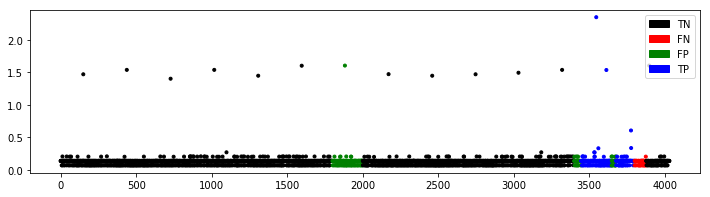

In [9]:
#A visiual representation of the model's performance
plt.figure(figsize=(12, 3))
import matplotlib.patches as mpatches 
index = ( label + 2*(preds >= 0.5))
cf = lambda x: 'k' if x==0 else ('r' if x == 1 else ('g' if x == 2 else 'b') )
cf = np.vectorize(cf)

color = cf(index)
black_patch = mpatches.Patch(color = 'black', label = 'TN')
red_patch = mpatches.Patch(color = 'red', label = 'FN')
green_patch = mpatches.Patch(color = 'green', label = 'FP')
blue_patch = mpatches.Patch(color = 'blue', label = 'TP')

plt.plot()
plt.legend(handles = [black_patch, red_patch, green_patch, blue_patch], loc= 'best')
plt.scatter(np.arange(len(data)), data, c=color, marker='.')

In [10]:
##Let's try AR
from ptsa.models.arima import ARIMA
model = ARIMA(window = 200, p_start=1, q_start=0,  max_p=5, max_q = 0, d= 0)
model.fit(data)

ARIMA(clean=False, contamination=0.1, d=0, max_p=5, max_q=0,
   neighborhood='all', p_start=1, q_start=0, window=200)

In [11]:
measure = Fourier()
measure.detector = model
measure.set_param()
model.decision_function(measure=measure)
grader.detect_model(model, label, is_A = True)

[0.9633709721839713, 0.5433333333333333, 0.815, 0.6519999999999999, 1.0, 0.815]

In [12]:
##Machine Learning based model
'''Machine Learning based model is different in that it doens't need a dissimilarity measure 
    Instead, it first transforms the data into multivariate array and then applied the algorithms
'''
#The Direct window approach just slides window and used that as each row
from ptsa.models.feature import Window
convertor = Window(window = 225)
X_train = convertor.convert(data)
print(X_train.shape, data.shape)
#keep in mind the difference in their length due to the transformation. We have to pad 0 to anomaly score after detection.

(3806, 225) (4031,)


In [13]:
#Example OCSVM
from ptsa.models.ocsvm import OCSVM
model = OCSVM()
model.fit(X_train)

OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)

In [14]:
#we have to specify the value of window so that the grader can know how pad 0 to make the score same dimension

'''Although OCSVM has a lower AUC score, its percision/recall is better. Meaning that if we don't clearly know 
    the thresholding value for determining anomalies, OCSVM may be a safer choice to implement.
    If we plot the anomalies, Its visual performance would also be better than those of the previous two. 
'''

grader.detect_model(model, label, window = 225)

[0.8857924814100799,
 0.868766404199475,
 0.8275,
 0.8476312419974391,
 1.0,
 0.5655]

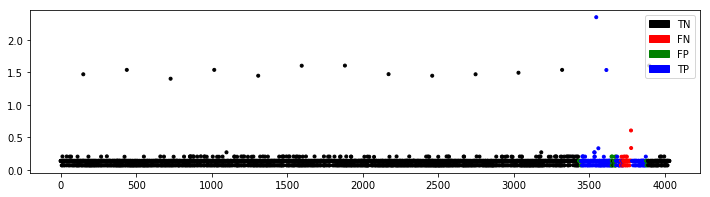

In [15]:
#Let's plot the detection of OCSVM
window = 225
preds = np.zeros(label.shape[0])
preds[math.floor(window/2) : - math.ceil(window/2)]  = grader.scale(model.decision_scores_, 0.1)

plt.figure(figsize=(12, 3))
import matplotlib.patches as mpatches 
index = ( label + 2*(preds >= 0.5))
cf = lambda x: 'k' if x==0 else ('r' if x == 1 else ('g' if x == 2 else 'b') )
cf = np.vectorize(cf)

color = cf(index)
black_patch = mpatches.Patch(color = 'black', label = 'TN')
red_patch = mpatches.Patch(color = 'red', label = 'FN')
green_patch = mpatches.Patch(color = 'green', label = 'FP')
blue_patch = mpatches.Patch(color = 'blue', label = 'TP')

plt.plot()
plt.legend(handles = [black_patch, red_patch, green_patch, blue_patch], loc= 'best')
plt.scatter(np.arange(len(data)), data, c=color, marker='.')